In [10]:
import random
from torchvision import transforms
import torch
import torch.nn as nn
from norb import smallNORB
import resnet
from capsule_network import resnet20 
import numpy as np

# ref https://discuss.pytorch.org/t/difference-between-torch-manual-seed-and-torch-cuda-manual-seed/13848/7
seed_value = 42
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `pytorch` pseudo-random generator at a fixed value
import torch

In [11]:
def get_test_loader(data_dir,
                    dataset,
                    batch_size, 
                    num_workers=4,
                    pin_memory=False):

    data_dir = data_dir + '/' + dataset

    from torchvision.transforms import InterpolationMode
    if dataset == "smallNorb":
        trans = [
                transforms.Resize(48, interpolation=InterpolationMode.BICUBIC),
                transforms.CenterCrop(32),
                transforms.ToTensor(),
                 ]
        dataset = smallNORB(data_dir, train=False, download=True,
                                transform=transforms.Compose(trans))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    print("type of test_loader", type(data_loader))
    print("Length of test_loader", len(data_loader))
    return data_loader


 import testing dataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': False}
batch_size = 64
test_loader = get_test_loader("./data", "smallNorb", batch_size, **kwargs)
num_test = len(test_loader.dataset)
print("Length of testing dataset", num_test)

type of test_loader <class 'torch.utils.data.dataloader.DataLoader'>
Length of test_loader 760
Length of testing dataset 48600


Initiliase the model

In [4]:
class VICReg(nn.Module):
    def __init__(self, arch):
        super().__init__()
        self.num_features = 2048
        self.backbone, _ = resnet.__dict__[arch](
            zero_init_residual=True 
        )
        self.projection_head = resnet20(16, {'size': 32, 'channels': 3, 'classes': 10}, 32, 16, 1, mode="SR").to("cuda")
    
    def forward(self, x ):
        x = self.projection_head(self.backbone(x))
        return x
 

Load the weights

In [5]:
model = VICReg("resnet18").cuda(device)
checkpoint = torch.load("checkpoints/vicreg_SR_linear_evaluation_after_pretrained_ckpt_epoch_100.pth.tar", map_location='cuda')  # or 'cpu'
model.load_state_dict(checkpoint['model_state'], strict=True)

<All keys matched successfully>

In [6]:
import torch
import json
# all of our models had 32 capsules
num_capsules = 32
# initialise them as 0
accumulated_activations = torch.zeros(num_capsules, device=device)

# Counter for the number of validation samples
num_samples = 0

for i, (x, y) in enumerate(test_loader):
    x = x.to(device) 
    with torch.no_grad(): 
        out = model(x)
    # Sum activations across the spatial dimensions for each capsule
    # and accumulate these sums across all validation samples
    accumulated_activations += torch.sum(out, dim=[0, 2, 3])
    # count the batches that have been processed
    num_samples += x.size(0)

# our activations are 4x4 (check the resnet file for more)
# so we divide by 16 to get the average activation per capsule element
average_activations = accumulated_activations / (num_samples * 16)  

average_activations_list = average_activations.cpu().tolist()

# Sanity checks
print("num_samples", num_samples)
print("accumulated_activations", accumulated_activations)
print("Average activations per capsule element:", average_activations_list)

# Save them to a JSON file for proof
data_to_save = {
    "capsule_averages": average_activations_list
}
file_path = 'capsules_averages/SR_linear_evaluation_capsule_averages_all.json'
with open(file_path, 'w') as f:
    json.dump(data_to_save, f, indent=4)

print(f"Saved activations averages to {file_path}")

num_samples 48600
accumulated_activations tensor([391847.3750, 389642.1250, 391051.0938, 394970.6562, 394286.3438,
        388697.9062, 387869.0312, 381498.6250, 379290.3125, 388739.6562,
        385252.5938, 393500.1562, 384836.7812, 386365.0625, 389211.3438,
        396645.4688, 385588.9062, 390991.6250, 396380.7812, 393016.8125,
        391504.1562, 392859.0625, 393627.7500, 389586.7500, 385886.2500,
        392486.4062, 391013.3750, 382475.8750, 386782.7812, 380198.7188,
        385095.9375, 387351.8438], device='cuda:0')
Average activations per capsule element: [0.5039189457893372, 0.5010829567909241, 0.502894937992096, 0.5079355239868164, 0.5070554614067078, 0.4998686909675598, 0.4988027513027191, 0.49061036109924316, 0.4877704679965973, 0.49992239475250244, 0.49543800950050354, 0.5060444474220276, 0.4949032664299011, 0.49686864018440247, 0.5005289912223816, 0.5100893378257751, 0.4958705008029938, 0.5028184652328491, 0.5097489356994629, 0.505422830581665, 0.5034775733947754, 0.50

Convert to a List for easier process

In [7]:
values_list = []
for value in data_to_save.values():
    values_list.extend(value)  
print("Flattened list of values:", values_list)

Flattened list of values: [0.5039189457893372, 0.5010829567909241, 0.502894937992096, 0.5079355239868164, 0.5070554614067078, 0.4998686909675598, 0.4988027513027191, 0.49061036109924316, 0.4877704679965973, 0.49992239475250244, 0.49543800950050354, 0.5060444474220276, 0.4949032664299011, 0.49686864018440247, 0.5005289912223816, 0.5100893378257751, 0.4958705008029938, 0.5028184652328491, 0.5097489356994629, 0.505422830581665, 0.5034775733947754, 0.5052199959754944, 0.5062085390090942, 0.5010117888450623, 0.4962528944015503, 0.5047407746315002, 0.5028464198112488, 0.4918671250343323, 0.4974058270454407, 0.48893868923187256, 0.4952365458011627, 0.4981376528739929]


round to 2 decimals as per the literature
https://arxiv.org/abs/2305.11178

In [8]:
avg = [round(num, 2) for num in values_list]
avg

[0.5,
 0.5,
 0.5,
 0.51,
 0.51,
 0.5,
 0.5,
 0.49,
 0.49,
 0.5,
 0.5,
 0.51,
 0.49,
 0.5,
 0.5,
 0.51,
 0.5,
 0.5,
 0.51,
 0.51,
 0.5,
 0.51,
 0.51,
 0.5,
 0.5,
 0.5,
 0.5,
 0.49,
 0.5,
 0.49,
 0.5,
 0.5]

Visualise

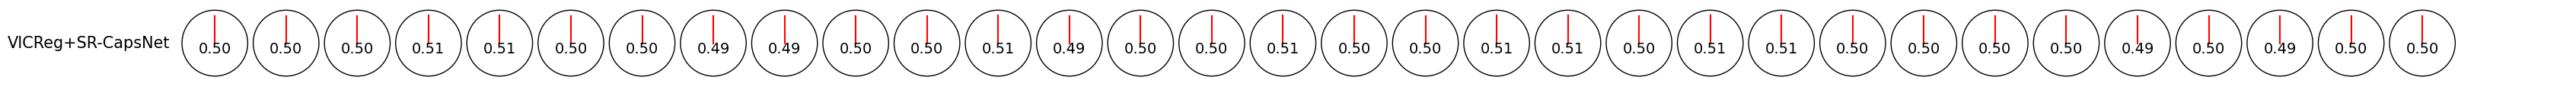

In [9]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

activations = avg 

fig, ax = plt.subplots(figsize=(34, 2.8))

# this is the space between circles
space_between_circles = 0.3 

# I make a circle for each capsule
for i, activation in enumerate(activations):
    circle_center = i * (1 + space_between_circles) + 1  
    circle = plt.Circle((circle_center, 0), 0.6, color='black', fill=False)
    ax.add_patch(circle)
    ax.plot([circle_center, circle_center], [0, activation], color='red')  
    ax.text(circle_center, -0.1, f'{activation:.2f}', ha='center', va='center', fontsize=14)

# add the name before the capsules at left 
ax.text(-1.3, 0, 'VICReg+SR-CapsNet', ha='center', va='center', fontsize=15)
ax.set_aspect('equal')
ax.axis('off')

# save into pdf for higher quality
plt.tight_layout()
plt.savefig('graphs_for_thesis/vicreg_sr_smallnorb_linear_evaluation.pdf', format='pdf')  
plt.show()